In [1]:
import sys
import os
import glob
from datetime import datetime
import re

import boto3
import cmocean
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from xarray import open_mfdataset
from netCDF4 import MFDataset, num2date
from matplotlib import image

from cloudflow.services.S3Storage import S3Storage
from cloudflow.job.Plotting import Plotting
from cloudflow.utils import romsUtil as utils

DEBUG = True

In [2]:
def roms_nosofs(COMDIR: str, OFS: str, HH: str):
    '''Load ROMS NOSOFS dataset'''

    filespec = f'{COMDIR}/nos.{OFS}.fields.f*.t{HH}z.nc'
    print(f'filespec is: {filespec}')
    return open_mfdataset(filespec, decode_times=False, combine='by_coords')

In [3]:
def dsofs_curr_fcst(COMROT: str='/com/nos'):
    """ Load the currently run OFS forecast on COMROT 
    This is almost the same as dosfs_newest, but will work better
    when running when injected in a workflow.
    It depends on a file being present in COMROT 'current.fcst'
    """
    
    dataset = 'testing' #'current' #'testing'
    
    if dataset:
        cur_file = f'{COMROT}/{dataset}.fcst'
        with open(cur_file) as cf:
            fcst = cf.read().rstrip(' \n')
    else:
        fcst = 'cbofs.2020082800' 

    print('fcst: ', fcst)
    
    COMDIR = f'{COMROT}/{fcst}'
    print('COMDIR: ', COMDIR)

    OFS = fcst.split('.')[0]
    fcstdate = fcst.split('.')[-1]
    HH = fcstdate[8:10]
    
    if DEBUG: # Only grab first 0-9 hours. Faster!
        filespec = f'{COMDIR}/nos.{OFS}.fields.f00*.t{HH}z.nc'
    else: # Grab all hours
        filespec = f'{COMDIR}/nos.{OFS}.fields.f*.t{HH}z.nc'
        
    print(f'filespec is: {filespec}')
    if OFS in utils.roms_models:
        return open_mfdataset(filespec, decode_times=False, combine='by_coords')
    elif OFS in utils.fvcom_models:
        return MFDataset(filespec)
    else:
        print(f"ERROR: model not recognized: {OFS}")
        return None

In [4]:
ds = dsofs_curr_fcst()

fcst:  ciofs.2020082800
COMDIR:  /com/nos/ciofs.2020082800
filespec is: /com/nos/ciofs.2020082800/nos.ciofs.fields.f00*.t00z.nc


In [5]:
ds

<xarray.Dataset>
Dimensions:          (boundary: 4, eta_psi: 1043, eta_rho: 1044, eta_u: 1044, eta_v: 1043, ocean_time: 9, s_rho: 30, s_w: 31, tracer: 2, xi_psi: 723, xi_rho: 724, xi_u: 723, xi_v: 724)
Coordinates:
    lon_v            (eta_v, xi_v) float64 dask.array<chunksize=(1043, 724), meta=np.ndarray>
    lat_u            (eta_u, xi_u) float64 dask.array<chunksize=(1044, 723), meta=np.ndarray>
    lon_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(1044, 724), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(1044, 724), meta=np.ndarray>
    lon_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(1043, 723), meta=np.ndarray>
    lat_v            (eta_v, xi_v) float64 dask.array<chunksize=(1043, 724), meta=np.ndarray>
    lat_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(1043, 723), meta=np.ndarray>
    lon_u            (eta_u, xi_u) float64 dask.array<chunksize=(1044, 723), meta=np.ndarray>
  * s_w              (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.03333 0.0
  * s_rho            (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time       (ocean_time) float64 1.47e+08 1.47e+08 ... 1.47e+08
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    ntimes           (ocean_time) int32 10800 10800 10800 ... 10800 10800 10800
    ndtfast          (ocean_time) int32 10 10 10 10 10 10 10 10 10
    dt               (ocean_time) float64 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0
    dtfast           (ocean_time) float64 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
    dstart           (ocean_time) float64 1.701e+03 1.701e+03 ... 1.701e+03
    nHIS             (ocean_time) int32 900 900 900 900 900 900 900 900 900
    ndefHIS          (ocean_time) int32 900 900 900 900 900 900 900 900 900
    nRST             (ocean_time) int32 0 0 0 0 0 0 0 0 0
    nSTA             (ocean_time) int32 90 90 90 90 90 90 90 90 90
    Falpha           (ocean_time) float64 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0
    Fbeta            (ocean_time) float64 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0
    Fgamma           (ocean_time) float64 0.284 0.284 0.284 ... 0.284 0.284
    Akt_bak          (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    Akv_bak          (ocean_time) float64 1e-05 1e-05 1e-05 ... 1e-05 1e-05
    Akk_bak          (ocean_time) float64 5e-06 5e-06 5e-06 ... 5e-06 5e-06
    Akp_bak          (ocean_time) float64 5e-06 5e-06 5e-06 ... 5e-06 5e-06
    rdrg             (ocean_time) float64 0.0003 0.0003 0.0003 ... 0.0003 0.0003
    rdrg2            (ocean_time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    Zob              (ocean_time) float64 0.01 0.01 0.01 0.01 ... 0.01 0.01 0.01
    Zos              (ocean_time) float64 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02
    Znudg            (ocean_time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    M2nudg           (ocean_time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    M3nudg           (ocean_time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    Tnudg            (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    FSobc_in         (ocean_time, boundary) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    FSobc_out        (ocean_time, boundary) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    M2obc_in         (ocean_time, boundary) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    M2obc_out        (ocean_time, boundary) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    Tobc_in          (ocean_time, boundary, tracer) float64 dask.array<chunksize=(1, 4, 2), meta=np.ndarray>
    Tobc_out         (ocean_time, boundary, tracer) float64 dask.array<chunksize=(1, 4, 2), meta=np.ndarray>
    M3obc_in         (ocean_time, boundary) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    M3obc_out        (ocean_time, boundary) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>

# Quiver plot

### Interpolate u, v to rho grid points

In [6]:
# Select u/v data (at water surface) and inspect 
u = ds.u.values[:, -1, :, :]
v = ds.v.values[:, -1, :, :]
print(f'u before (ds.u.shape): {u.shape}')
print(f'v before (ds.v.shape): {v.shape}')

# Interpolate u/v to rho coordinates
ds['u_rho'] = (('ocean_time', 'eta_rho', 'xi_rho'), np.ma.masked_values(np.zeros_like(ds.zeta), 0.0))
ds['v_rho'] = (('ocean_time', 'eta_rho', 'xi_rho'), np.ma.masked_values(np.zeros_like(ds.zeta), 0.0))
ds.u_rho[:, 1:, 1:] = (u[:, 0:-1, :] + u[:, 1:, :]) * 0.5
ds.v_rho[:, 1:, 1:] = (v[:, :, 0:-1] + v[:, :, 1:]) * 0.5
print(f'u after (ds.u_rho.shape): {ds.u_rho.shape}')
print(f'v after (ds.v_rho.shape): {ds.v_rho.shape}')

u before (ds.u.shape): (9, 1044, 723)
v before (ds.v.shape): (9, 1043, 724)
u after (ds.u_rho.shape): (9, 1044, 724)
v after (ds.v_rho.shape): (9, 1044, 724)


In [7]:
ds0 = ds.isel(ocean_time=0)

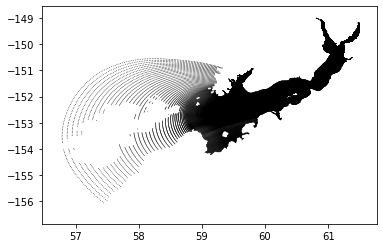

In [8]:
u = ds0.u_rho.values
v = ds0.v_rho.values

x = ds0.lat_rho.values
y = ds0.lon_rho.values

ax = plt.axes()
ax.quiver(x, y, u, v)

# Scratch

# Calculate speed and direction
This isn't actually necessary for quiver plots

In [9]:
# Magnitudes
ds['vmag_rho'] = (('ocean_time', 'eta_rho', 'xi_rho'), np.ma.masked_values(np.zeros_like(ds.zeta), 0.0))
ds['vmag_rho'] = np.sqrt(np.square(ds.u_rho) + np.square(ds.v_rho))

# Directions
ds['vdir_rho'] = (('ocean_time', 'eta_rho', 'xi_rho'), np.ma.masked_values(np.zeros_like(ds.zeta), 0.0))
ds['vdir_rho'] = np.arctan(ds.v_rho/ds.u_rho)